# **Tensorflow-Keras and Scikit-Learn With MLRun**

_______________________________________________________________________________

MLRun is an open-source Python package that provides a framework for running machine learning tasks transparently in multiple, scalable, runtime environments.  MLRun provides tracking of code, metadata, inputs, outputs and the results of machine learning pipelines. 

In this notebook we"ll compose a pipeline that deploys a classifier model, and uses it as the input in a training and validation step. We'll be working with a synthetic features matrix of dimension 10 million rows by 20 features and a binary label.  The model will be a 2-layer neural net classifier using **[tensorflow-keras](https://www.tensorflow.org/)** (v2.0.0b1), without gpu support.

The dataset we create is balanced, however there is a `weight` parameter in the data generator function specifying the fraction of observations that are labeled 0/False. The number of samples and features are also parameters.  The demonstration could be modified easily to allow for a more fine-grained control over the simulated dataset either by adding more parameters or replacing the underlying function altogether.

The training and validation step employs a scikit learn `Pipeline` to perform feature engineering. Some of the feature engineering needs to be done _**after**_ the train-valid-test set split. In some preprocessing scenarios we might estimate a data transformation on the training set before model training, and then apply the estimate to the validation and test sets before prediction. Since we need to perform the same transformation pre-inference, all pipeline model steps are stored.

Serializing models can be challenging for number of reasons:  a pipeline with multiple steps may require just as many encoding and decoding routines--applying joblib to a Keras model that has been wrapped in a scikit-learn api fails.  Since we have the model architecture in a class definition, all we need to do is save the weights.  Some steps in a pipeline may have no internal state to store, while others can be stored and loaded using `joblib`.  Most of it all boils down to storing dicts/json with numpy objects.

One of the upsides of the present architecture is that we can mix many simulations of data with a given model estimator, or many models with a given data sample and track everything in **MLRun**.  Research, development, and deployment, all on one page, running under multiple configurations, limited only by the compute resources at our disposal.


#### **notebook take-aways**
* write and test reusable and replaceable **[MLRun](https://github.com/mlrun)** components in a notebook, file or github repository
* store and load models
* run the components as a **[KubeFlow](https://www.kubeflow.org/)** pipeline

<a id='top'></a>
#### **steps**
**[install the python mlrun package](#install)**<br>
**[nuclio code section](#nuclio-code-section)**<br>
    - [nuclio's ignore](#ignore)<br>
    - [function dependencies](#function-dependencies)<br>

**[components](#components)**<br>
    - [supporting functions](#imports)<br>
    - [data simulation](#data_generator)<br>
    - [feature engineering](#feateng)<br>
    - [a classifier](#classifier)<br>
    - [save and load pipeline model](#save-load)<br>
    - [training and validation](#train)<br>
**[local tests](#local-testing)**<br>
**[remote tests](#remote)**<br>
**[compose pipeline](#compose)**<br>
**[run](#run)**<br>

<a id="install" ></a>
______________________________________________

# **notebook installs**

The following will reinstall the latest development version of ```mlrun```:

    !pip uninstall mlrun -y

    !pip install mlrun

Install the KubeFlow pipelines package ```kfp```. For more information see the **[KubeFlow documentation on nuclio](https://www.kubeflow.org/docs/components/misc/nuclio/)** and  **[Kubeflow pipelines and nuclio](https://github.com/kubeflow/pipelines/tree/master/components/nuclio)**. For logging the estimated machine learning models we'll use ```joblib```'s ```dump``` and ```load```. For more details see **[Joblib: running Python functions as pipeline jobs](https://joblib.readthedocs.io/en/latest/index.html)**.

    !pip install numpy==1.16.4
    !pip install -U kfp joblib 
    !pip install -U seaborn matplotlib 
    !pip install -U scikit-learn pandas tensorflow==2.0.0b1
    !pip install git+https://github.com/yjb-ds/functions-demo.git

<a id="nuclio-code-section"><a>
______________________________________________

# **nuclio code section**

<a id='ignore'></a>
### _nuclio's **ignore** notation_

You"ll write all the code that gets packaged for execution between the tags ```# nuclio: ignore```, meaning ignore all the code here and above, and ```# nuclio: end-code```, meaning ignore everything after this annotation.  The **[docs](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** also suggest another approach: we can use ```# nuclio: start``` at the first relevant code cell instead of marking all the cells above with ```# nuclio: ignore```.

See the **[nuclio-jupyter](https://github.com/nuclio/nuclio-jupyter)** repo for further information on these and many other **[nuclio magic commands](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** that make it easy to transform a Jupyter notebook environment into a platform for developing production-quality, machine learning systems.

The ```nuclio-jupyter``` package provides methods for automatically generating and deploying nuclio serverless functions from code, repositories or Jupyter notebooks. **_If you have never run nuclio functions in your notebooks, please uncomment and run the following_**:

    !pip install nuclio-jupyter

The following two lines _**should be in the same cell**_ and mark the start of your mchine learning coding section:

In [1]:
# nuclio: ignore
import nuclio 

<a id="function-dependencies"></a>
### _function dependencies_

The installs made in the section **[Setup](#Setup)** covered the Jupyter environment within which this notebook runs.  However, we need to ensure that all the dependencies our nuclio function relies upon (such as ```matplotlib```, ```sklearn```, ```lightgbm```), will be available when that code is wrapped up into a nuclio function _**on some presently unknown runtime**_.   Within the nuclio code section we can ensure these dependencies get built into the function with the ```%nuclio cmd``` magic command.

In [2]:
%nuclio cmd -c pip install matplotlib 
%nuclio cmd -c pip install tensorflow==2.0.0b1 
%nuclio cmd -c pip install sklearn 
%nuclio cmd -c pip install pandas 
%nuclio cmd -c pip install numpy==1.16.4 
%nuclio cmd -c pip install joblib
%nuclio cmd -c pip install mlrun
%nuclio cmd -c pip install git+https://github.com/yjb-ds/functions-demo.git

We"ll use a standard base image here, however the build step can be shortened by preparing images with pre-installed packages.

In [3]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


<a id="support"></a>
### _imports_

Some of the functionality is provided in custom components within the ```functions``` package (found at the github repo **[function-demos](https://github.com/yjb-ds/functions-demo)**):<br>

- **[datasets](functions/datasets.py)**:&emsp;generate simulation data
- **[files](functions/file_fs.py)**:&emsp;&emsp;&emsp;save and load _remote_ files
- **[models](function/model_fs.py)**:&nbsp; &emsp;save, load, and instantiate models
- **[plots](functions/plot_fs.py)**:&emsp;  &emsp; sundry plotting functions
- **[tables](functions/tables.py)**:&emsp; &nbsp; &nbsp;logging and retrieving table artifacts

In [4]:
from functions.datasets import create_binary_classification
from functions.models import (FeaturesEngineer, 
                              classifier, 
                              class_instance,
                              pipeline_save,
                              pipeline_load)
from functions.plots import (plot_validation,
                             plot_roc,
                             plot_confusion_matrix)

In [5]:
import os
from typing import Any, Union, Optional, List

In [6]:
import joblib
import json
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

<a id='paths'></a>
### _paths and parameters_

In [10]:
TARGET_PATH = '/User/mlrun/simdata'

# data simulation and ml training parameter
BATCH_SIZE = 1_024
LEARNING_RATE = 0.1
EPOCHS= 3
N_SAMPLES = 100_000
M_FEATURES = 20
CLASS_BALANCE = 0.5
DROPOUT = 0.5

<a id="components" ></a>
______________________________________________

# **components**

<a id='data_generator'></a>
## **data generator**

In [11]:
def data_generator(
    context: MLClientCtx,
    samples: int,
    features: int,
    features_hdr: Optional[List[str]],
    neg_weight: float,
    target_path: str,
    key: str
) -> None:
    """Generate raw data for this pipeline
    
    This component will be the entry point of the pipeline.
    
    In this demonstration our component is a simple wrapper for scikit learn's 
    `make_classification`, a convenient utility enabling us to build
    and test a pipeline from start to finish with a clean and 
    predictable dataset. By fiddling with neg_weight, we can also take a 
    quick look at the effect of class balance on our model before exposing it
    to the kind of data we find in the real world.
    
    :param context:       function context
    :param samples:       number of samples (rows) to generate
    :param features:      number of features (cols)
    :param features_hdr:  (optional) header for the features array
    :param neg_weights:   fraction of negative samples
    :param target_path:   destination for data including file name
    :param key:           context key of data
    """
    if features_hdr:
        assert len(features_hdr)==m_features, f"features header dimension mismatch for {name}"
    data = create_binary_classification(
                context, n_samples=samples, m_features=features,
                features_hdr=features_hdr,  weight=neg_weight, 
                target_path=target_path, key=key)

<a id='feateng'></a>
## **feature engineering**

This class implements the scikit-learn transformer API, enabling it to fit into an sklearn `Pipeline` as a step.<br>

For code please see the custom sklearn transformer `FeaturesEngineer` in **[models.py](functions/models.py)**.  

<a id="classifier"></a>
## **classifier**

This method generates a small keras Sequential model with 2 layers which gets wrapped in a `KerasClassifier` class. The latter provides it with a convenient sklearn interface for use in **[sklearn Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn-pipeline-pipeline)**. The list of metrics collected during training can also be found in the same module as `METRICS` and includes accuracy, precision, recall, auc and a confusion matrix.<br>

For code please see `KerasClassifier` and `model_gen` in **[models.py](functions/models.py)**.  

<a id='save-load'></a>
## **save and load pipeline models**

The model presented here has three stages, wrapped into an sklearn pipeline:
1. **feature engineer**&emsp;&emsp; `function.models.FeaturesEngineer`
2. **scaler**&nbsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp;&nbsp; `sklearn.preprocessing.StandardScaler`
3. **classifier**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;`functions.models.Classifier`, a `KerasClassifier` wrapper

In order to save this model pipeline, each of its components may have to be saved independently.

In our pipeline, the `FeaturesEngineer` has no state so we just create a new one during load. 

The `StandardScaler`'s estimates need to be re-used when transforming new data, so it is pickled using `joblib` (it contains arrays) with `xxxxx-scaler.pickle` as a filename.

Keras models have an architecture saved as json, and corresponding weights are saved in hdf5 format. The architecture can be recreated by instantiating the class or converting the json representation into a model, with the weights loaded into that structure. Filenames for the model are `xxxxx-weights.h5` and `xxxxx-model.json`.

For code please see `pipeline_save` and `pipeline_load` in **[models.py](functions/models.py)**.  

<a id='train'></a>
## **training and validation**

In this notebook demonstration we follow standard practice by wrapping the training/validation and test steps into the same method.

**exercise / todos**

To complete the demonstration, instead of hard-coding the `train_test_split` method, add a splitter class into the pipeline, like a cross-validator. 

The model encoder/decoder could also be input as a parameter.

In [12]:
import io
def train(
    context: MLClientCtx,
    dataset: DataItem,
    engineer_cls: str,
    scaler_cls: str,
    classifier_cls: str,
    target_path: str,
    model_key: str = '',
    test_data_key: str = '',
    metrics_key: str = '',
    test_size: float = 0.1,
    valid_size: float = 0.3,
    batch_size: int = 1024,
    epochs: int = 5,
    verbose: bool = True,
    random_state: int = 1,
    ) -> None:
    """Train, validate, test and save a classifier model pipeline.
    
    Here we split the data, instantiate our pipeline and its models, and proceed
    to training and validation.
    
    The target_path defines the base folder where artifacts will be stored.  Since we
    intend to save both the model (and its components), the test set and its predictions,
    and the history of metric estimates we provide three keys.
    
    :param context:             function context
    :param dataset:             cleaned input dataset
    :param engineer_cls:        feature engineering class
    :param scaler_cls:          scaler class
    :param classifier_cls:      classifier class    
    :param target_path:         destination (folder) for artifact files
    :param model_key:           model key in the artifact store
    :param test_data_key:       test set and predictions key in the artifact store
    :param metrics_key:         metrics key in the artifact store
    :param test_size:           (0.1) test set size as fraction
    :param valid_size:          (0.3) validation set size as fraction
    :param batch_size:          (1024) network feed batch size
    :param epochs:              (5) training epochs
    :param verbose:             (default True) Show metrics for 
                                training/validation steps
        
    Also included for demonstration are a randomly selected sample
    of training parameters:
    :param learning_rate: Step size at each iteration, constant.
    """
    raw = pd.read_parquet(io.BytesIO(dataset.get()), engine='pyarrow')

    train, test = train_test_split(raw, test_size=test_size)
    train, valid = train_test_split(train, test_size=valid_size)
    
    y_train = train.pop('labels')
    y_valid = valid.pop('labels')
    y_test = test.pop('labels')

    # instantiate features engineer, scaler and classifier
    Engineer = class_instance(engineer_cls)
    Scaler = class_instance(scaler_cls)
    classifier = class_instance(classifier_cls)

    pipe = Pipeline(steps=[('engineer', Engineer()),
                           ('scaler', Scaler()),
                           ('keras_model', classifier)])
    pipe.fit(train, y_train,
             keras_model__epochs=epochs, 
             keras_model__batch_size=batch_size,
             keras_model__validation_split=0.25) # fudge

    y_pred = pipe.predict(test)                          
    acc = accuracy_score(y_test, y_pred)
    # log the final model accuracy
    context.log_result("accuracy", float(acc))
    
    # we can generate a number of metrics plots with the predictions
    # and labels, so we'll save these
    test['predictions'] = y_pred
    test['labels'] = y_test
    test_data_path = os.path.join(target_path,'test_data.parquet')
    pq.write_table(pa.Table.from_pandas(test), test_data_path)
    
    # log the test_data file as an artifact under 'metrics_key'
    context.log_artifact(test_data_key, target_path=test_data_path)
    
    # we also save the entire training history with multiple per epoch 
    # metrics in one table and make them available for plotting, for example
    metrics = pd.DataFrame(pipe.named_steps.keras_model.model.history.history)
    metrics.index.name = 'epoch'
    metrics_path = os.path.join(target_path,'metrics.parquet')
    pq.write_table(pa.Table.from_pandas(metrics), metrics_path)
    
    # log the metrics file as an artifact under 'metrics_key'
    context.log_artifact(metrics_key, target_path=metrics_path)

    pipeline_save(context, pipe, target_path, model_key)

#### _end of nuclio function definition_

In [13]:
# nuclio: end-code

<a id="local-testing" ></a>
______________________________________________

# **testing your code locally**

The function can be run locally and debugged/tested before deployment:

In [14]:
from mlrun import (mlconf,
                   code_to_function,
                   new_function,
                   NewTask,
                   new_model_server,
                   mount_v3io)  

Set MLRun's DB path.  MLRun wil generate and store all of its tracking and metadata to the `MLRUN_DBATH` environment variable.  We have set a `TARGET_PATH` earlier in this notebook in the above section **[paths and parameters](#paths)**.

In [15]:
mlconf.dbpath = 'http://mlrun-api:8080'

In [16]:
workflow = new_function()

In [17]:
datagen_run = workflow.run(
    name='data generator',
    handler=data_generator,
    params={
        'samples':      N_SAMPLES,
        'features':     M_FEATURES,
        'neg_weight':   CLASS_BALANCE, # this is a balanced dataset
        'target_path':  TARGET_PATH,
        'key':          'simdata'})

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...0f793a,0,Jan 04 15:45:54,completed,data generator,host=jupyter-788f6ff784-m6fh2,,samples=100000features=20neg_weight=0.5target_path=/User/mlrun/simdatakey=simdata,,simdata


to track results use .show() or .logs() or in CLI: 
!mlrun get run 929ac13780584e978a87179f090f793a  , !mlrun logs 929ac13780584e978a87179f090f793a 
[mlrun] 2020-01-04 15:45:55,331 run executed, status=completed


In [18]:
train_run = workflow.run(
    name='train, validate and store model',
    handler=train,
    inputs={
        'dataset': datagen_run.outputs['simdata']},
    params={
        'scaler_cls':     'sklearn.preprocessing.data.StandardScaler',
        'engineer_cls':   'functions.models.FeaturesEngineer',
        'classifier_cls': 'functions.models.classifier',
        'target_path':     TARGET_PATH,
        'model_key':       'model_dir',
        'test_data_key':   'test_data',
        'metrics_key':     'metrics',
        'batch_size':      BATCH_SIZE,
        'epochs':          25})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/conda/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train on 47250 samples, validate on 15750 samples
Epoch 1/25
47250/47250 [==============================] - 1s 21us/sample - loss: 0.8266 - tp: 8131.0000 - fp: 4683.0000 - tn: 18838.0000 - fn: 15598.0000 - accuracy: 0.5708 - precision: 0.6345 - recall: 0.3427 - auc: 0.5888 - val_loss: 0.6370 - val_tp: 2989.0000 - val_fp: 957.0000 - val_tn: 6913.0000 - val_fn: 4891.0000 - val_accuracy: 0.6287 - val_precision: 0.7575 - val_recall: 0.3793 - val_auc: 0.7364
Epoch 2/25
47250/47250 [==============================] - 0s 4us/sample - loss: 0.6710 - tp: 11489.0000 - fp: 4876.0000 - tn: 18645.0000 - fn: 12240.0000 - accuracy: 0.6378 - precision: 0.7020 - recall: 0.4842 - auc: 0.6893 - val_loss: 0.5210 - val_tp: 5099.0000 - val_fp: 887.0000 - val_tn: 6983.0000 - val_fn: 2781.0000 - val_accuracy: 0.7671 - val_precision: 0.8518 - val_recall: 0.6471 - val_auc: 0.8794
Epoch 3/25
47250/47250 [==============================] - 0s 4us/sample - loss: 0.5772 - tp: 13999.0000 - fp: 4543.0000 - tn: 18978.00

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...e7f3b2,0,Jan 04 15:45:55,completed,"train, validate and store model",host=jupyter-788f6ff784-m6fh2,dataset,scaler_cls=sklearn.preprocessing.data.StandardScalerengineer_cls=functions.models.FeaturesEngineerclassifier_cls=functions.models.classifiertarget_path=/User/mlrun/simdatamodel_key=model_dirtest_data_key=test_datametrics_key=metricsbatch_size=1024epochs=25,accuracy=0.9669,test_datametricsmodel_dir


to track results use .show() or .logs() or in CLI: 
!mlrun get run 72c4bf9f47ab4bb7abeca0b5d4e7f3b2  , !mlrun logs 72c4bf9f47ab4bb7abeca0b5d4e7f3b2 
[mlrun] 2020-01-04 15:46:02,211 run executed, status=completed


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...9af092,0,Jan 04 15:46:02,completed,training history,host=jupyter-788f6ff784-m6fh2,metrics,fmt=pngtarget_path=/User/mlrun/simdatakey=training,,training


to track results use .show() or .logs() or in CLI: 
!mlrun get run 22ab271071a74747835cb0812e9af092  , !mlrun logs 22ab271071a74747835cb0812e9af092 
[mlrun] 2020-01-04 15:46:02,475 run executed, status=completed


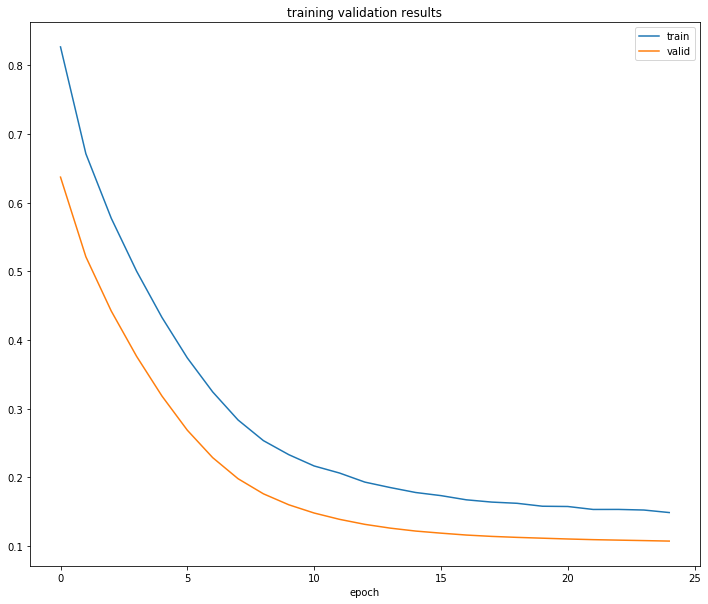

In [19]:
plot_history = workflow.run(
    name='training history',
    handler=plot_validation,
    inputs={'metrics': train_run.outputs['metrics']},
    params={
        'fmt': 'png',
        'target_path': TARGET_PATH,
        'key' : 'training',})

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...189a22,0,Jan 04 15:46:02,completed,confusion matrix,host=jupyter-788f6ff784-m6fh2,test_data,"labels=[0, 1]target_path=/User/mlrun/simdatakey=confusion_matrix",,confusion_matrix


to track results use .show() or .logs() or in CLI: 
!mlrun get run b806362806e241b0b1605b64ca189a22  , !mlrun logs b806362806e241b0b1605b64ca189a22 
[mlrun] 2020-01-04 15:46:02,910 run executed, status=completed


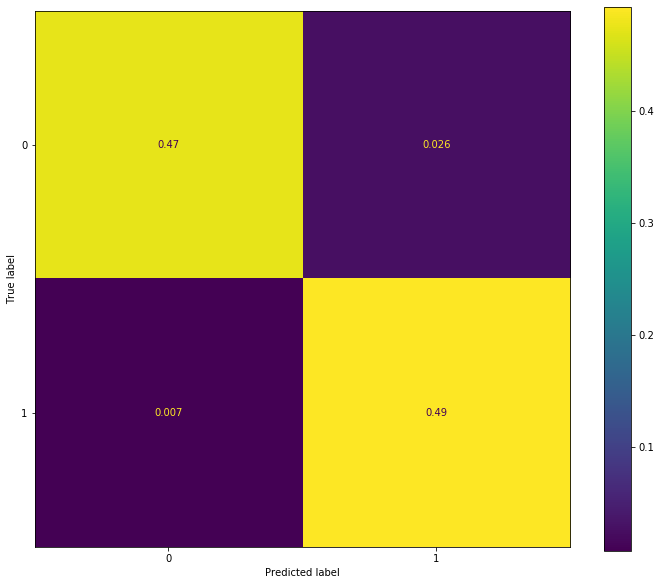

In [20]:
plot_history = workflow.run(
    name='confusion matrix',
    handler=plot_confusion_matrix,
    inputs={'test_data': train_run.outputs['test_data']},
    params={'labels': [0, 1],
            'target_path': TARGET_PATH, 
            'key': 'confusion_matrix'}
)

<a id="image"></a>
#### _Create a deployment image_

Once debugged you can create a reusable image, and then deploy it for testing. In the following line we are converting the code block between the ```#nuclio: ignore``` and ```#nuclio: end-code``` to be run as a KubeJob. _**It is important to ensure that this function has been `deploy`ed at least once, and that you have access to it.**_

In [21]:
tfkeras_job = code_to_function(name='tfkeras_named_pipe',
                               runtime="job").apply(mount_v3io())

# set this to True so that updates to our git package are reflected in the built image,
# but please note however that this may lengthen image build times:
# tfkeras_job.spec.no_cache = True

In [22]:
tfkeras_job.deploy()

[mlrun] 2020-01-04 15:46:06,448 starting remote build, image: .mlrun/func-default-tfkeras-named-pipe-latest
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b905d77fa0bfb06e29e5aabf075c7941ea687f1c125a: no such file or directory 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b905d77fa0bfb06e29e5aabf075c7941ea687f1c125a: no such file or directory 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0001] Unpacking rootfs as cmd RUN pip install matplotlib requires it. 
INFO[0011] Taking snapsho

True

<a id="remote"></a>
# **test your code remotely**

In [23]:
task = NewTask()

task.with_params(samples=N_SAMPLES,
                 features=M_FEATURES,
                 neg_weight=CLASS_BALANCE,
                 target_path=TARGET_PATH,
                 key='simdata')

nrun = tfkeras_job.run(task, 
                       handler='data_generator', 
                       out_path=TARGET_PATH)

[mlrun] 2020-01-04 15:51:24,927 starting run data_generator uid=ae1e0360d8114210b6ae338730c24951  -> http://mlrun-api:8080
2020-01-04 15:52:00.225901: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-04 15:52:00.232231: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2020-01-04 15:52:00.234275: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5c80920 executing computations on platform Host. Devices:
2020-01-04 15:52:00.234300: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
[mlrun] 2020-01-04 15:52:01,008 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...c24951,0,Jan 04 15:52:00,completed,tfkeras-named-pipe,host=data-generator-97kn9kind=jobowner=admin,,features=20key=simdataneg_weight=0.5samples=100000target_path=/User/mlrun/simdata,,simdata


to track results use .show() or .logs() or in CLI: 
!mlrun get run ae1e0360d8114210b6ae338730c24951  , !mlrun logs ae1e0360d8114210b6ae338730c24951 
[mlrun] 2020-01-04 15:52:04,291 run executed, status=completed


In [24]:
task.with_input('dataset', nrun.outputs['simdata'])

task.with_params(scaler_cls='sklearn.preprocessing.data.StandardScaler',
                 engineer_cls='functions.models.FeaturesEngineer',
                 classifier_cls='functions.models.classifier',
                 target_path=TARGET_PATH,
                 model_key='model_dir',
                 test_data_key='test_data',
                 metrics_key='metrics',
                 batch_size=BATCH_SIZE,
                 epochs=10)

nrun2 = tfkeras_job.run(task,
                       handler='train',
                       out_path=TARGET_PATH)

[mlrun] 2020-01-04 15:52:04,298 starting run train uid=802eaeebfc4a4ee58fb9392a7fb35195  -> http://mlrun-api:8080
2020-01-04 15:52:13.361851: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-04 15:52:13.368855: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2020-01-04 15:52:13.370444: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ff6180 executing computations on platform Host. Devices:
2020-01-04 15:52:13.370467: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-01-04 15:52:15.043357: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1483] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you w

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...b35195,0,Jan 04 15:52:13,completed,tfkeras-named-pipe,host=train-q8fmmkind=jobowner=admin,dataset,batch_size=1024classifier_cls=functions.models.classifierengineer_cls=functions.models.FeaturesEngineerepochs=10metrics_key=metricsmodel_key=model_dirscaler_cls=sklearn.preprocessing.data.StandardScalertarget_path=/User/mlrun/simdatatest_data_key=test_data,accuracy=0.9621,test_datametricsmodel_dir


to track results use .show() or .logs() or in CLI: 
!mlrun get run 802eaeebfc4a4ee58fb9392a7fb35195  , !mlrun logs 802eaeebfc4a4ee58fb9392a7fb35195 
[mlrun] 2020-01-04 15:52:19,666 run executed, status=completed


In [25]:
task.with_input('metrics', nrun2.outputs['metrics'])

task.with_params(fmt='png', target_path=TARGET_PATH, key='training')

nrun3 = tfkeras_job.run(task, handler='plot_validation', out_path=TARGET_PATH)

[mlrun] 2020-01-04 15:52:19,672 starting run plot_validation uid=3452b8de121243748e729e3eaa49017e  -> http://mlrun-api:8080
2020-01-04 15:52:30.504727: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-04 15:52:30.511759: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2020-01-04 15:52:30.513410: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5d467c0 executing computations on platform Host. Devices:
2020-01-04 15:52:30.513435: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
[mlrun] 2020-01-04 15:52:31,030 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...49017e,0,Jan 04 15:52:30,completed,tfkeras-named-pipe,host=plot-validation-54mlbkind=jobowner=admin,datasetmetrics,fmt=pngkey=trainingtarget_path=/User/mlrun/simdata,,training


to track results use .show() or .logs() or in CLI: 
!mlrun get run 3452b8de121243748e729e3eaa49017e  , !mlrun logs 3452b8de121243748e729e3eaa49017e 
[mlrun] 2020-01-04 15:52:38,996 run executed, status=completed


In [26]:
task.with_input('test_data', nrun2.outputs['test_data'])

task.with_params(labels=[0, 1], fmt='png', target_path=TARGET_PATH, key='confusion_matrix')

nrun4 = tfkeras_job.run(task, handler='plot_confusion_matrix', out_path=TARGET_PATH)

[mlrun] 2020-01-04 15:52:39,002 starting run plot_confusion_matrix uid=d58f7306e26542479c76d1e6c42d8c7c  -> http://mlrun-api:8080
2020-01-04 15:52:47.602524: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-04 15:52:47.609309: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2020-01-04 15:52:47.610961: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6a1a1e0 executing computations on platform Host. Devices:
2020-01-04 15:52:47.610982: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
[mlrun] 2020-01-04 15:52:48,145 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...2d8c7c,0,Jan 04 15:52:47,completed,tfkeras-named-pipe,host=plot-confusion-matrix-pndpgkind=jobowner=admin,datasetmetricstest_data,"fmt=pngkey=confusion_matrixlabels=[0, 1]target_path=/User/mlrun/simdata",,confusion_matrix


to track results use .show() or .logs() or in CLI: 
!mlrun get run d58f7306e26542479c76d1e6c42d8c7c  , !mlrun logs d58f7306e26542479c76d1e6c42d8c7c 
[mlrun] 2020-01-04 15:52:51,347 run executed, status=completed


<a id="compose"></a>
# **Create a KubeFlow Pipeline from our functions**

Our pipeline will consist of two steps, ```data_generator``` and ```train```.

For complete details on KubeFlow Pipelines please refer to the following docs:
1. **[KubeFlow pipelines](https://www.kubeflow.org/docs/pipelines/)**.
2. **[kfp.dsl Python package](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#module-kfp.dsl)**.

Please note, the model server file name in the ```new_model_server``` function call below should identical in every respect to the name of the model server notebook (here, **[model_server.ipynb](#model-server.ipynb)**).

In [27]:
import kfp
from kfp import dsl

In [28]:
srvfn = new_model_server("tfkeras",  
                         model_class="MyKerasClassifier",   
                         filename="model_server.ipynb")
srvfn.apply(mount_v3io())

In [36]:
@dsl.pipeline(
    name="Sklearn and KubeFlow",
    description="Shows how to use mlrun/kfp."
)
def tfkeras_pipeline(
    neg_weight = [0.5, 0.1],
):

    datagen = tfkeras_job.as_step(
        name='data generator',
        handler='data_generator',
        out_path=TARGET_PATH, 
        params={        
            'samples':         N_SAMPLES,
            'features':        M_FEATURES,
            'neg_weight':      CLASS_BALANCE,
            'target_path':     TARGET_PATH,
            'key':            'simdata'},
        outputs=['simdata']).apply(mount_v3io())
    
    train = tfkeras_job.as_step(
        name='sklearn pipe train',
        handler='train',
        out_path=TARGET_PATH, 
        inputs={'dataset': datagen.outputs['simdata']},
        outputs=['model_dir', 'test_data', 'metrics'],
        params={
            'scaler_cls':     'sklearn.preprocessing.data.StandardScaler',
            'engineer_cls':   'functions.models.FeaturesEngineer',
            'classifier_cls': 'functions.models.classifier',
            'target_path':     TARGET_PATH,
            'model_key':      'model_dir',
            'test_data_key':  'test_data',
            'metrics_key':    'metrics',
            'batch_size':      BATCH_SIZE,
            'epochs':          10}).apply(mount_v3io())

    plot_valid = tfkeras_job.as_step(
        name='plot training validation accuracy',
        handler='plot_validation',
        out_path=TARGET_PATH, 
        inputs={'metrics': train.outputs['metrics']},
        params={
            'target_path':     TARGET_PATH,
            'key':             'history',
            'fmt':             'png'}).apply(mount_v3io())

    plot_confusion = tfkeras_job.as_step(
        name='plot confusion matrix',
        handler='plot_confusion_matrix',
        out_path=TARGET_PATH, 
        inputs={'test_data': train.outputs['test_data']},
        outputs=['model_dir'],
        params={
            'labels':          [0, 1], 
            'target_path':     TARGET_PATH,
            'key':             'confusion',
            'fmt':             'png'}).apply(mount_v3io())

    # define a nuclio-serving function, generated from a notebook file
    srvfn.deploy_step(project="mlrun_demos", 
                      models={"tfkeras_joblib": train.outputs["model_dir"]})

<a id="compile the pipeline"></a>
### _compile the pipeline_

We can compile our KubeFlow pipeline and produce a yaml description of the pipeline worflow:

In [37]:
# os.makedirs(TARGET_PATH, exist_ok=True)
kfp.compiler.Compiler().compile(tfkeras_pipeline, TARGET_PATH+"/mlrunpipe.yaml")

In [38]:
client = kfp.Client(namespace="default-tenant")

Finally, the following line will run the pipeline as a job::

In [39]:
arguments = {
    'neg_weight' : [0.5, 0.1]    
}

run_result = client.create_run_from_pipeline_func(
    tfkeras_pipeline, 
    arguments, 
    run_name="tfkeras",
    experiment_name="tfkeras")

In [33]:
# !mlrun clean